# GenePermuter
A repository for all scripts created and used toward Figure 3 from:

## Rapidly evolving protointrons in Saccharomyces genomes revealed by a hungry spliceosome

Jason Talkish, Haller Igel, Rhonda J Perriman, Lily Shiue, Sol Katzman, Elizabeth M Munding, Robert Shelansky, John Paul Donohue,  Manuel Ares Jr.

doi: https://doi.org/10.1101/515197
https://www.biorxiv.org/content/early/2019/01/09/515197


1. /src  detailing orf shuffling and statistics completed for figure3.
2. /data describes how the curated "intronless" ORF set was created. 

Initital Rendition of figure 3 with reversed colors...:(. Glad I caught that.
<img src="files/Error.png">

In [1]:
##Dependencies
import Bio.SeqIO    #Reading Fasta
import collections  
import numpy        
import itertools   
import bisect       
from matplotlib import pyplot as plt
%matplotlib inline
##PLOTTING STYLE
font = {'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)

## Helper Functions For Permutation and Counting

In [2]:
##Functions for Counting kmers and Permuting groups of ORFS
def kmerGenerator(seqs, ksize = 5):
    """ Takes a list of sequence and counts kmers of size ksize.
    """
    return(seq[i:i+ksize] for seq in seqs for i in range(len(seq) - ksize + 1))

def permuteOrfs(orfs, iterations):
    """ Takes a list of sequences that are mod%3=0 and shuffles codons for each orf returning a list of sequences.
    """
    orfs      = [[orf[i:i+3] for i in range(0,len(orf)-3+1,3)] for orf in orfs]
    starts    = numpy.char.array([orf[0 ]     for orf in orfs])
    stops     = numpy.char.array([orf[-1]     for orf in orfs])
    internals = numpy.array(     [orf[1:-1]   for orf in orfs])
    for i in range(iterations):
        any(map(numpy.random.shuffle, internals)) #does the perumtations
        yield( map("".join, zip(starts, map("".join, internals), stops)))

## Permutation and Counting

In [3]:
extent_path = r'C:\\Users\\Robert\\Desktop\\Manny\\S288C\\curated_orf.fasta'
ksize           = 6
iterations      = 10000
all_6mers       = list(map("".join, itertools.product(['A','C','G','T'],repeat=ksize)))
extent_orfs     = [str(record.seq).upper() for record in Bio.SeqIO.parse(extent_path, "fasta")]
extent_kmers    = collections.Counter( kmerGenerator(extent_orfs,ksize = ksize))
all_stop_codons = [kmer for kmer in all_6mers if any((x in kmer) for x in ['TAA', 'TGA', 'TAG']) ]
all_start_codons= [kmer for kmer in all_6mers if 'ATG' in kmer]
start_select    = numpy.array ([(kmer in all_start_codons) for kmer in all_6mers ])
stop_select     = numpy.array ([(kmer in all_stop_codons ) for kmer in all_6mers ])
GTATGT          = all_6mers.index('GTATGT')
ACTAAC          = all_6mers.index('ACTAAC')


In [4]:
#DOING THE PERMUTING
###COUTNING ALL PERMUTED GENOMES
# counter = {kmer:[0]*iterations for kmer in all_5_6_mers}
# for i, permuted_orfs in enumerate(permuteOrfs(extent_orfs, iterations)):        
#     permuted_orfs  = list(permuted_orfs)
#     permuted_6mers = collections.Counter(kmerGenerator(permuted_orfs, ksize = 6))
#     for kmer in all_6mers:
#         counter[kmer][i] = permuted_kmers[kmer] 
        
## ##Code to save data just in case
## with open(r'C:\Users\Robert\Desktop\Manny\kmers.tab','w') as file:
##     for kmer in all_5_6_mers:
##         print("{}\t{}".format(kmer,"\t".join(str(count) for count in counter[kmer])),file=file)
## ##Code to read the data just in case

##Pre Computed Kmers for ease of running. To do multiple replicates simply run above.
counter = {kmer:[] for kmer in all_6mers}
with open(r'C:\Users\Robert\Desktop\Manny\kmers.tab','r') as file:
    for line in file:
        line = line.split()
        counter[line[0]] = [int(count) for count in  line[1:]]


## Statistics and Plotting

In [5]:
kmer_counts   = numpy.array([[counter[kmer][i] for i in range(iterations)] for kmer in all_6mers]) / len(extent_orfs) 
extent_counts = numpy.array([extent_kmers[kmer]  for kmer in all_6mers]) / len(extent_orfs)
extent_rank   = numpy.array([bisect.bisect_left(sorted(counter[kmer]), extent_kmers[kmer])+1 for kmer in all_6mers])


means         = numpy.mean (kmer_counts,axis=1)
sd            = numpy.std  (kmer_counts,axis=1)
zscore        = (extent_counts - means) / sd

rank          = numpy.argsort(zscore)
stop_rank     = numpy.arange(len(stop_select))[stop_select][numpy.argsort(zscore[stop_select])]
start_rank    = numpy.arange(len(start_select))[start_select][numpy.argsort(zscore[start_select])]

print('MOTIF:zscore\trank/total')
print('{}:{}\t{}/{}\t{}/{}'.format('ACTAAC ',
                                 zscore[ ACTAAC ],
                                 numpy.where(rank == ACTAAC)[0][0],
                                 len(all_6mers),
                                 numpy.where(stop_rank == ACTAAC)[0][0],
                                 len(stop_rank) ))

print('MOTIF:zscore\trank/total')
print('{}:{}\t{}/{}\t{}/{}'.format('GTATGT ',
                                 zscore[ GTATGT ],
                                 numpy.where(rank == GTATGT)[0][0],
                                 len(all_6mers),
                                 numpy.where(start_rank == GTATGT)[0][0],
                                 len(start_rank) ))

MOTIF:zscore	rank/total
ACTAAC :-12.253574555246939	153/4096	91/759
MOTIF:zscore	rank/total
GTATGT :-6.978990139779191	671/4096	7/255


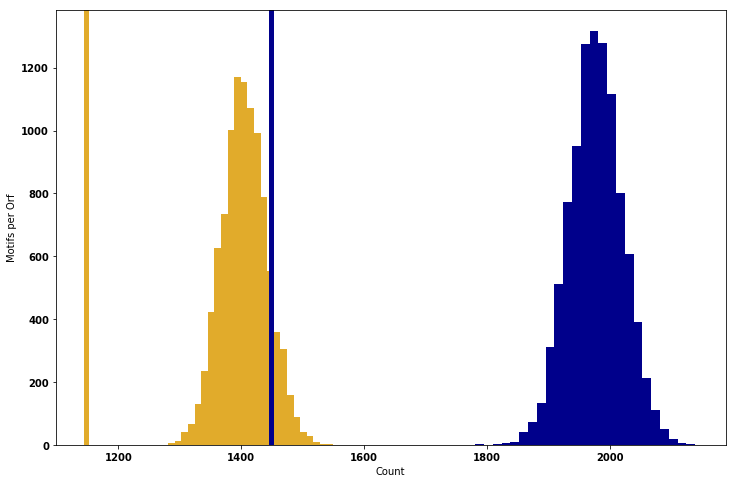

In [6]:
# deviding by the number of orfs can yield a motifs/orf metric instead of total motifs  using [ /len(extent_orfs)]
plt.figure(figsize=(12,8))
plt.title('ACTAAC Motif in Shuffled Genome')
plt.hist(numpy.array(counter[ 'ACTAAC' ]), bins=25,color='darkblue'    )
plt.axvline(extent_kmers[ 'ACTAAC' ]     ,lw=5, color='darkblue')

plt.xlabel('Count')
plt.ylabel('Motifs per Orf')
plt.title('')

plt.hist(numpy.array(counter[ 'GTATGT' ]) , bins=25,color='#E1AB2B')
x=plt.axvline(extent_kmers[ 'GTATGT' ]     ,lw=5, color='#E1AB2B')
#plt.xlim([0.175,0.5])
plt.xlabel('Count')
x=plt.ylabel('Motifs per Orf')
plt.savefig(r'C:\Users\Robert\Desktop\fig3A.png',dpi=600)

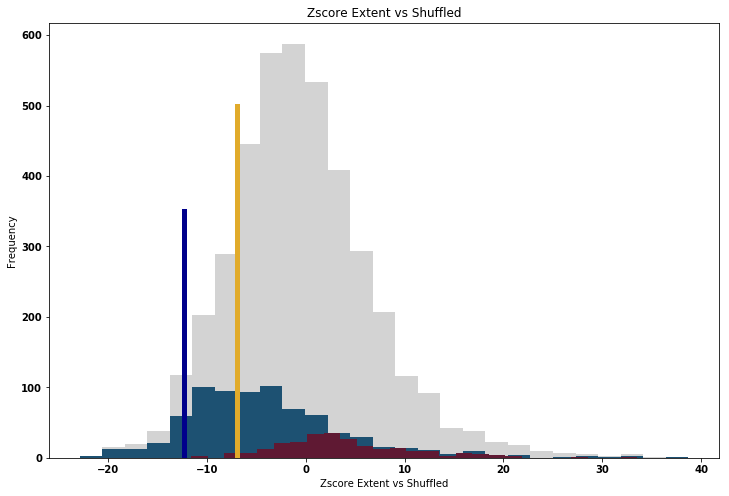

In [7]:
fig=plt.figure(figsize=(12,8))
x=plt.hist(zscore             , bins=27, color='darkgrey',alpha = 0.5)
x=plt.hist(zscore[stop_select], bins=27, color='#1d5172')#'#90743E'
x=plt.hist(zscore[start_select], bins=27,color='#5F1933')#'#1d5172'
# x   = plt.axvline(zscore[ GTATGT ] ,lw=5, color='darkblue')
x   = plt.plot( [zscore[ ACTAAC ]]*2,(0,350) ,lw=5, color='darkblue')
x   = plt.plot( [zscore[ GTATGT ]]*2,(0,500) ,lw=5, color='#E1AB2B')
plt.xlabel('Zscore Extent vs Shuffled')
x=plt.ylabel('Frequency')
x=plt.title('Zscore Extent vs Shuffled')
plt.savefig(r'C:\Users\Robert\Desktop\test.png',dpi=600)

## Extent vs Shuffled Kmer distrobutions for all Kmers

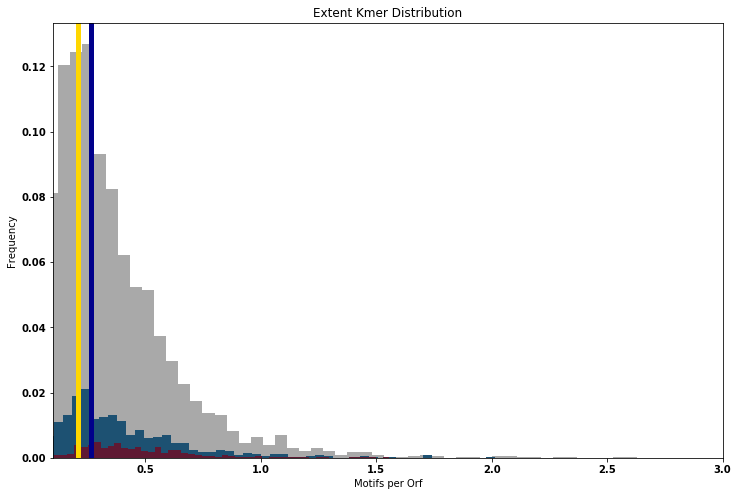

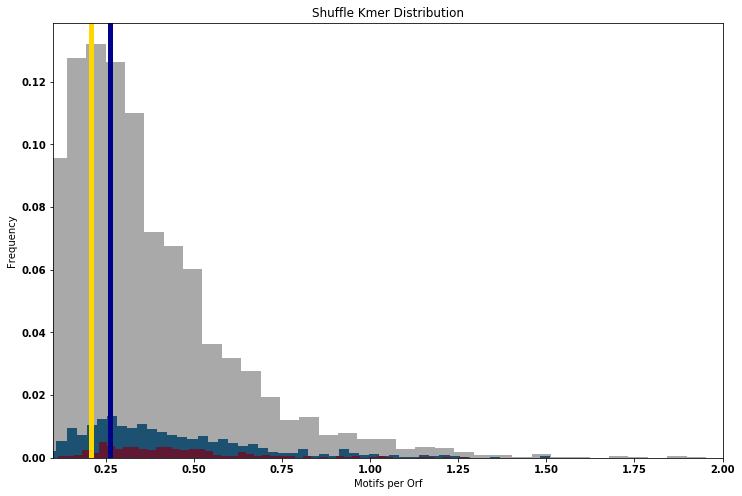

In [8]:
plt.figure(figsize=(12,8))
extent_dist = numpy.array([extent_kmers[kmer] for kmer in all_6mers])/len(extent_orfs)
x = plt.hist(extent_dist, bins=50,weights = numpy.ones_like(extent_dist)/len(extent_dist)  , color='darkgrey')
x = plt.hist(extent_dist[stop_select], bins=50,weights = numpy.ones_like(extent_dist[stop_select])/len(extent_dist), color='#1d5172')
x = plt.hist(extent_dist[start_select], bins=50,weights = numpy.ones_like(extent_dist[start_select])/len(extent_dist), color='#5F1933')

x = plt.axvline(extent_kmers[ 'GTATGT' ] /len(extent_orfs),lw=5, color='gold')
x = plt.axvline(extent_kmers[ 'ACTAAC' ] /len(extent_orfs),lw=5, color='darkblue')
x = plt.axvline(extent_kmers[ 'ACTAAC' ] /len(extent_orfs),lw=5, color='darkblue')
x = plt.axvline(extent_kmers[ 'GTATGT' ] /len(extent_orfs),lw=5, color='gold')


plt.xlim([0.1,3])
plt.xlabel('Motifs per Orf')
x=plt.ylabel('Frequency')
x=plt.title('Extent Kmer Distribution')


shuffle_dist        = numpy.array([sum(counter[kmer]) for kmer in all_6mers])      / len(extent_orfs) / iterations
plt.figure(figsize=(12,8))
x   = plt.hist(shuffle_dist      ,bins=50, weights = numpy.ones_like (extent_dist) /len(extent_dist)  , color='darkgrey')
x   = plt.hist(shuffle_dist[stop_select]      ,bins=50, weights = numpy.ones_like (extent_dist[stop_select]) /len(extent_dist)  , color='#1d5172')
x   = plt.hist(shuffle_dist[start_select]      ,bins=50, weights = numpy.ones_like (extent_dist[start_select]) /len(extent_dist)  , color='#5F1933')

x   = plt.axvline(extent_kmers[ 'GTATGT' ] /len(extent_orfs),lw=5, color='gold')
x   = plt.axvline(extent_kmers[ 'ACTAAC' ] /len(extent_orfs),lw=5, color='darkblue')
plt.xlim([0.1,2])
plt.xlabel('Motifs per Orf')
x=plt.ylabel('Frequency')
x=plt.title('Shuffle Kmer Distribution')

## Codon and AA analysis Bias

In [9]:
###ANALYSIS of Amino acid pair biasis  
rnaCodonTable = {
    #
    'UUU': 'F', 'UCU': 'S', 'UAU': 'Y', 'UGU': 'C',  # UxU
    'UUC': 'F', 'UCC': 'S', 'UAC': 'Y', 'UGC': 'C',  # UxC
    'UUA': 'L', 'UCA': 'S', 'UAA': '-', 'UGA': '-',  # UxA
    'UUG': 'L', 'UCG': 'S', 'UAG': '-', 'UGG': 'W',  # UxG
    # C
    'CUU': 'L', 'CCU': 'P', 'CAU': 'H', 'CGU': 'R',  # CxU
    'CUC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',  # CxC
    'CUA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R',  # CxA
    'CUG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',  # CxG
    # A
    'AUU': 'I', 'ACU': 'T', 'AAU': 'N', 'AGU': 'S',  # AxU
    'AUC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',  # AxC
    'AUA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R',  # AxA
    'AUG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',  # AxG
    # G
    'GUU': 'V', 'GCU': 'A', 'GAU': 'D', 'GGU': 'G',  # GxU
    'GUC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',  # GxC
    'GUA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G',  # GxA
    'GUG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'   # GxG
    }
codonTable = {codon.replace('U','T'): amino for codon,amino in rnaCodonTable.items()}
aaTable       = collections.defaultdict(set)
for codon, aa in codonTable.items():
    aaTable[aa].add(codon)
    
def getAllKmersFromKmer(kmer):
    assert(len(kmer)==6)
    first  = aaTable[codonTable[kmer[:3]]]
    second = aaTable[codonTable[kmer[3:]]]
    return(["".join(kmer) for kmer in itertools.product(first,second)])



Text(0,0.5,'Motifs per Orf')

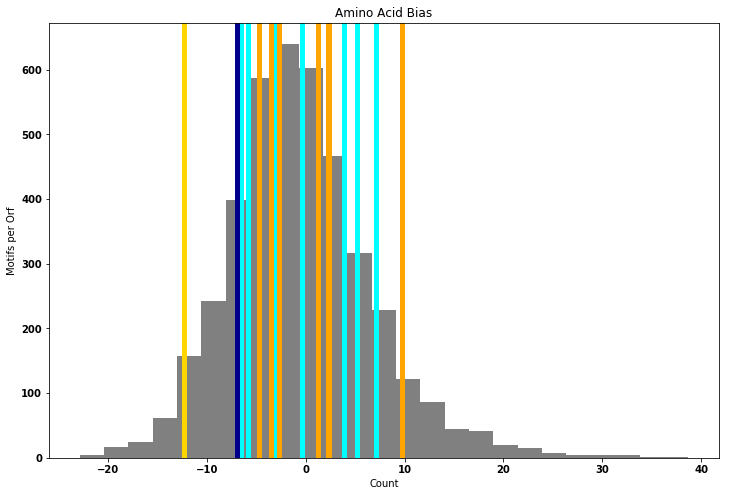

In [10]:
TN = set(getAllKmersFromKmer('ACTAAC'))
VC = set(getAllKmersFromKmer('GTATGT'))
TN_select = numpy.array([kmer in TN for kmer in all_6mers])
VC_select = numpy.array([kmer in TN for kmer in all_6mers])
plt.figure (figsize=(12,8))
plt.title  ('Amino Acid Bias')
plt.hist   (zscore, bins=25,color='grey')
for kmer in TN:
    plt.axvline(zscore[ all_6mers.index(kmer)]     ,lw=5, color='cyan'      )
for kmer in VC:
    plt.axvline(zscore[ all_6mers.index(kmer)]     ,lw=5, color='orange'      )
plt.axvline(zscore[ GTATGT],lw=5,color='darkblue')
plt.axvline(zscore[ ACTAAC],lw=5,color='gold')
plt.xlabel ('Count')
plt.ylabel ('Motifs per Orf')

## TA Dinucleotide Analysis

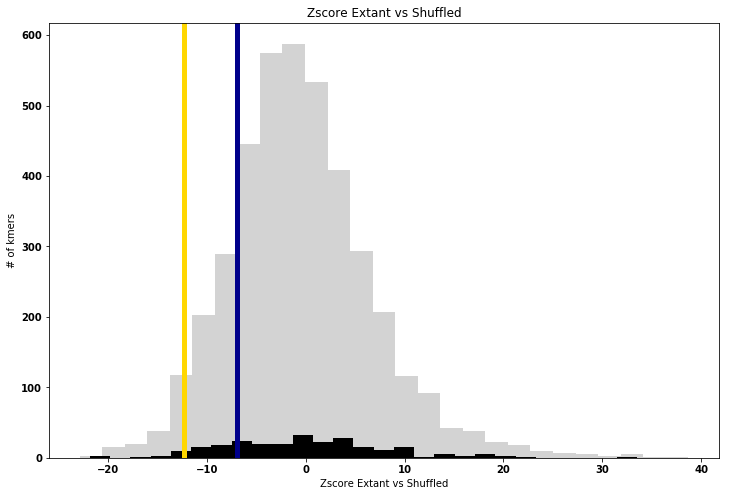

In [11]:
##DINUCLEOTIDE ANALYSIS
tadicodon = { "".join((N1,N2,'AT',N5,N6)) for N1,N2,N5,N6 in  itertools.product('ATGC',repeat = 4)}
ta_select = numpy.array([(kmer in tadicodon) for kmer in all_6mers ])

plt.figure(figsize=(12,8))
x=plt.hist(zscore             , bins=27, color='darkgrey',alpha = 0.5)
x=plt.hist(zscore[ta_select], bins=27, color='black')#'#90743E'
# x   = plt.axvline(zscore[ GTATGT ] ,lw=5, color='darkblue')
x   = plt.axvline(zscore[ ACTAAC ] ,lw=5, color='gold')
x   = plt.axvline(zscore[ GTATGT ] ,lw=5, color='darkblue')
plt.xlabel('Zscore Extant vs Shuffled')
x=plt.ylabel('# of kmers')
x=plt.title('Zscore Extant vs Shuffled')

##Shuffled vs Extent Kmer distributions
# plt.figure(figsize=(12,8))
# extent_dist = numpy.array([extent_kmers[kmer] for kmer in all_6mers])/len(extent_orfs)
# ta_dist     = numpy.array([extent_kmers[kmer] for kmer in tadicodon])/len(extent_orfs)
# x=plt.hist(extent_dist,bins=50  , color='darkgrey')
# x=plt.hist(ta_dist,bins=50  , color='black')

# x=plt.axvline(extent_kmers[ 'GTATGT' ] /len(extent_orfs),lw=5, color='gold')
# x=plt.axvline(extent_kmers[ 'ACTAAC' ] /len(extent_orfs),lw=5, color='darkblue')
# plt.xlabel('Motifs per Orf')
# x=plt.ylabel('Count')
# x=plt.title('Extant Kmer Distribution')

# shuffle_dist        = numpy.array([sum(counter[kmer]) for kmer in all_6mers])      / len(extent_orfs) / iterations
# plt.figure(figsize=(12,8))
# x   = plt.hist(shuffle_dist      ,bins=50, weights = numpy.ones_like (extent_dist) /len(extent_dist)  , color='darkgrey')
# x   = plt.hist(shuffle_dist[ta_select]      ,bins=50, weights = numpy.ones_like (extent_dist[ta_select]) /len(extent_dist)  , color='black')
# x   = plt.axvline(extent_kmers[ 'GTATGT' ] /len(extent_orfs),lw=5, color='gold')
# x   = plt.axvline(extent_kmers[ 'ACTAAC' ] /len(extent_orfs),lw=5, color='darkblue')
# plt.xlabel('Motifs per Orf')
# x=plt.ylabel('Frequency')
# x=plt.title('Shuffle Kmer Distribution')